# Bài tập thực hành 1
## Xây dựng mô hình Naïve Bayes trên tập dữ liệu hành vi của khách hàng

### 1. Import thư viện và nạp dữ liệu

In [9]:
# Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Nạp dữ liệu Customer Behaviour từ file đã cung cấp
df = pd.read_csv('marketing_campaign.csv')

# Xem qua dữ liệu
print("Thông tin dữ liệu:")
print(df.info())
print("\n5 hàng đầu tiên:")
print(df.head())
print("\nCác cột trong dữ liệu:", df.columns.tolist())
print("\nMô tả thống kê:")
print(df.describe())

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB
None

5 hàng đầu tiên:
    User ID  Gender  Age  EstimatedSalary  Purchased
0  15624510    Male   19            19000          0
1  15810944    Male   35            20000          0
2  15668575  Female   26            43000          0
3  15603246  Female   27            57000          0
4  15804002    Male   19            76000          0

Các cột trong dữ liệu: ['User ID', 'Gender', 'Age', 'EstimatedSalary', 'Purchased']

Mô tả thống kê:
            User ID         Age  EstimatedSalary   Purchased
count  

### 2. Tiền xử lý dữ liệu

In [10]:
# Chọn các đặc trưng số liên quan và xử lý giá trị thiếu
numeric_features = ['Age', 'EstimatedSalary']  # Dựa trên cột có sẵn trong dữ liệu
numeric_features = [col for col in numeric_features if col in df.columns]

# Xử lý giá trị thiếu bằng trung vị
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

# Mã hóa cột phân loại (Gender)
categorical_cols = ['Gender']  # Chỉ có Gender là cột phân loại
label_encoders = {}
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# Sử dụng cột 'Purchased' làm nhãn (Purchase_Intention)
if 'Purchased' in df.columns:
    df['Purchase_Intention'] = df['Purchased']
else:
    raise ValueError("Không tìm thấy cột nhãn 'Purchased' để sử dụng!")

# Loại bỏ cột không cần thiết (User ID)
X = df[numeric_features + categorical_cols]
y = df['Purchase_Intention']

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Chia dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Kích thước tập train: {X_train.shape}")
print(f"Kích thước tập test: {X_test.shape}")
print(f"Phân phối nhãn: {y.value_counts()}")

Kích thước tập train: (320, 3)
Kích thước tập test: (80, 3)
Phân phối nhãn: Purchase_Intention
0    257
1    143
Name: count, dtype: int64


### 3. Xây dựng và huấn luyện mô hình Gaussian Naive Bayes

In [11]:
# Khởi tạo và huấn luyện mô hình Gaussian Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred = nb_model.predict(X_test)
y_pred_proba = nb_model.predict_proba(X_test)[:, 1]  # Xác suất cho lớp 1

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

Accuracy: 0.88
ROC AUC Score: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90        51
           1       0.85      0.79      0.82        29

    accuracy                           0.88        80
   macro avg       0.87      0.86      0.86        80
weighted avg       0.87      0.88      0.87        80



### 4. Vẽ Confusion Matrix

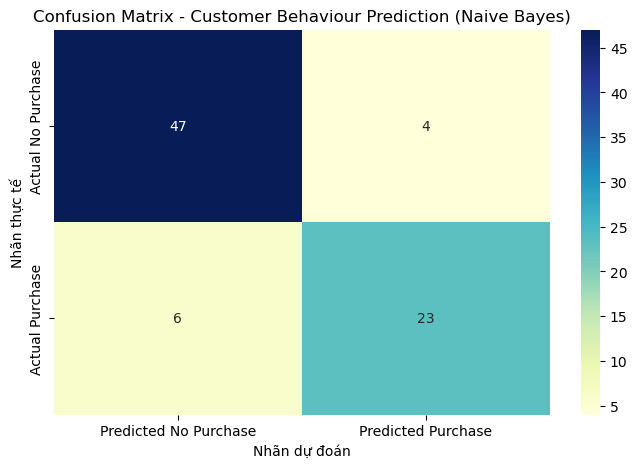

Confusion Matrix:
                    Predicted No Purchase  Predicted Purchase
Actual No Purchase                     47                   4
Actual Purchase                         6                  23


In [12]:
# Tính Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
conf_matrix = pd.DataFrame(data=cm, columns=['Predicted No Purchase', 'Predicted Purchase'], 
                          index=['Actual No Purchase', 'Actual Purchase'])

# Vẽ Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title('Confusion Matrix - Customer Behaviour Prediction (Naive Bayes)')
plt.ylabel('Nhãn thực tế')
plt.xlabel('Nhãn dự đoán')
plt.show()

print("Confusion Matrix:")
print(conf_matrix)

### 5. Vẽ biểu đồ phân phối dự đoán vs thực tế

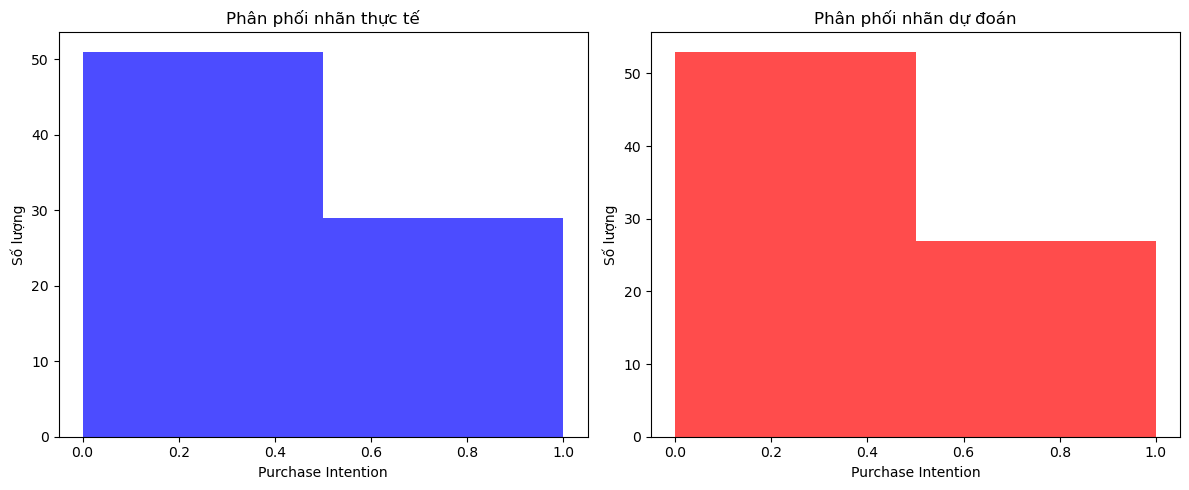

In [13]:
# Vẽ biểu đồ so sánh y_test và y_pred
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Phân phối thực tế
axes[0].hist(y_test, bins=2, alpha=0.7, label='Actual', color='blue')
axes[0].set_title('Phân phối nhãn thực tế')
axes[0].set_xlabel('Purchase Intention')
axes[0].set_ylabel('Số lượng')

# Phân phối dự đoán
axes[1].hist(y_pred, bins=2, alpha=0.7, label='Predicted', color='red')
axes[1].set_title('Phân phối nhãn dự đoán')
axes[1].set_xlabel('Purchase Intention')
axes[1].set_ylabel('Số lượng')

plt.tight_layout()
plt.show()

### 6. Tối ưu hóa mô hình với Cross-Validation

In [14]:
# Import Cross Validation
from sklearn.model_selection import cross_val_score

# Đánh giá với 5-fold Cross Validation
cv_scores = cross_val_score(nb_model, X_scaled, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

Cross-Validation Scores: [0.8375 0.9625 0.9375 0.8125 0.8875]
Mean CV Accuracy: 0.89 (+/- 0.11)
